# Generating Synthetic PV Power Time Series

In [ ]:
import os
import yaml
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [3]:
config_path = "config.yaml"
config = load_config(config_path)

dir = config['data']['final_data']
params = config['synth']

installed_power = 100
surface_tilt = 10
surface_azimuth = 10
gamma_pdc = -0.0035
albedo = 0.25

plot_names = ['Total', 'Direct', 'Diffuse']

In [4]:
files = os.listdir(dir)
file = files[0]

df = pd.read_csv(os.path.join(dir, file))
df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['timestamp'] = df['timestamp'].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
df.set_index('timestamp', inplace=True)

df.drop(['  QN_x', '  QN_y', '  QN'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79200 entries, 2023-05-26 00:00:00 to 2024-11-25 23:50:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATIONS_ID    79200 non-null  int64  
 1   PP_10          79200 non-null  float64
 2   TT_10          79200 non-null  float64
 3   TM5_10         79200 non-null  float64
 4   RF_10          79200 non-null  float64
 5   TD_10          79200 non-null  float64
 6   FF_10          79200 non-null  float64
 7   DD_10          79200 non-null  int64  
 8   DS_10          79200 non-null  float64
 9   GS_10          79200 non-null  float64
 10  SD_10          79200 non-null  float64
 11  LS_10          79200 non-null  int64  
 12  Stationshoehe  79200 non-null  float64
 13  geoBreite      79200 non-null  float64
 14  geoLaenge      79200 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 9.7 MB


In [ ]:
def get_features(data: pd.DataFrame, 
                 params: list,
                 surface_tilt: float, 
                 surface_azimuth: float, 
                 albedo: float
                ):
    # calculate pressure
    #pressure = pvlib.atmosphere.alt2pres(elevation)
    dhi = data[params['dhi']['param']]
    ghi = data[params['ghi']['param']]
    pressure = data[params['pressure']['param']]
    temperature = data[params['temperature']['param']]
    v_wind = data[params['v_wind']['param']]
    latitude = data[params['latitude']['param']]
    longitude = data[params['longitude']['param']]
    elevation = data[params['elevation']['param']]
    
    # get solar position
    solpos = pvlib.solarposition.get_solarposition(
        time=data.index,
        latitude=latitude,
        longitude=longitude,
        altitude=elevation,
        temperature=temperature,
        pressure=pressure,
    )
    solar_zenith = solpos['zenith']
    solar_azimuth = solpos['azimuth']
    
    # GHI and DHI in W/m^2 --> J / cm^2 = J / 0,0001 m^2 = 10000 J / m^2 --> Dividing by 600 seconds (DWD is giving GHI as sum of 10 minutes))
    dhi = data[params['dhi']['param']] * 1e4 / 600
    ghi = data[params['ghi']['param']] * 1e4 / 600
    
    # get dni from ghi, dni and zenith
    dni = pvlib.irradiance.dni(ghi=ghi,
                               dhi=dhi,
                               zenith=solar_zenith)
    
    # get total irradiance
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_zenith,
        solar_azimuth=solar_azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        dni_extra=pvlib.irradiance.get_extra_radiation(data.index),
        albedo=albedo,
        model='haydavies',
    )
    
    cell_temperature = pvlib.temperature.faiman(total_irradiance['poa_global'], 
                                                temperature,
                                                v_wind, 
                                                u0=25.0, 
                                                u1=6.84)
    
    return total_irradiance, cell_temperature


def generate_pv_power(total_irradiance: pd.Series,
                      cell_temperature: pd.Series,
                      installed_power: float,
                      gamma_pdc: float
                      ) -> pd.Series:
    
    power_dc = pvlib.pvsystem.pvwatts_dc(total_irradiance, 
                                         cell_temperature, 
                                         installed_power,
                                         gamma_pdc=gamma_pdc, 
                                         temp_ref=25.0)
    
    return pvlib.inverter.pvwatts(power_dc, 
                                  installed_power, 
                                  eta_inv_nom=0.96, 
                                  eta_inv_ref=0.9637)
    
    
def plot_power_and_features(day: str, 
                            plot_names: list,
                            features: list,
                            power: pd.Series,
                            synchronize_axes=True
                            ): 

    day = pd.Timestamp(day)
    index_0 = power.index.get_loc(day)
    index_1 = power.index.get_loc(day + pd.Timedelta(days=1))
    date = str(features[0].index[index_0:index_1][0].date())

    fig, ax1 = plt.subplots(figsize=(10, 6))
    fontsize = 14
    lines = []
    title_suffix = ''
    
    # plot power
    line1, = ax1.plot(
    power[index_0:index_1],
    label="Power Output (W)",
    color="black",
    linewidth=2.0
    )
    lines.append(line1)

    # configure secondary y-axis
    ax1.set_xlabel("Time", fontsize=fontsize)
    ax1.set_ylabel("Power Output (W)", fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2)
    
    ax2 = ax1.twinx()
    # plot irradiance components
    for name, series in zip(plot_names, features):
        line, = ax2.plot(
            series[index_0:index_1],
            label=f"{name} (W/m$^2$)",
            linestyle='--',
            linewidth=2.0
        )
        lines.append(line)

    # configure primary y-axis
    ax2.set_ylabel("Energy flux density (W/m$^2$)", fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    # Format x-axis to show only hours (HH)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ticks = ax1.get_xticks()
    ax1.set_xticks(ticks[1:-1])


    # Synchronize y-axes
    if synchronize_axes:
        title_suffix = '(synched axes)'
        all_ghi_min = min([series[index_0:index_1].min() for series in features])
        all_ghi_max = max([series[index_0:index_1].max() for series in features])
        y_min = min(all_ghi_min, power[index_0:index_1].min())
        y_max = max(all_ghi_max, power[index_0:index_1].max())
        ax1.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)

    # legend
    lines.append(lines.pop(0))
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=fontsize)

    plt.title(f"Irradiance and Power Output on {date} {title_suffix}", fontsize=fontsize)
    fig.tight_layout()
    #plt.grid(True)

    plt.show()

In [7]:
total_irradiance, cell_temperature = get_features(data=df,
                                                  params=params,
                                                  surface_tilt=surface_tilt,
                                                  surface_azimuth=surface_azimuth, 
                                                  albedo=albedo)
total = total_irradiance['poa_global']
direct = total_irradiance['poa_direct']
diffuse = total_irradiance['poa_diffuse']
#sky_dhi = total_irradiance['poa_sky_diffuse']
#ground_dhi = total_irradiance['poa_ground_diffuse']
features = [total, direct, diffuse]

power = generate_pv_power(total_irradiance=total,
                          cell_temperature=cell_temperature,
                          installed_power=installed_power, 
                          gamma_pdc=gamma_pdc)

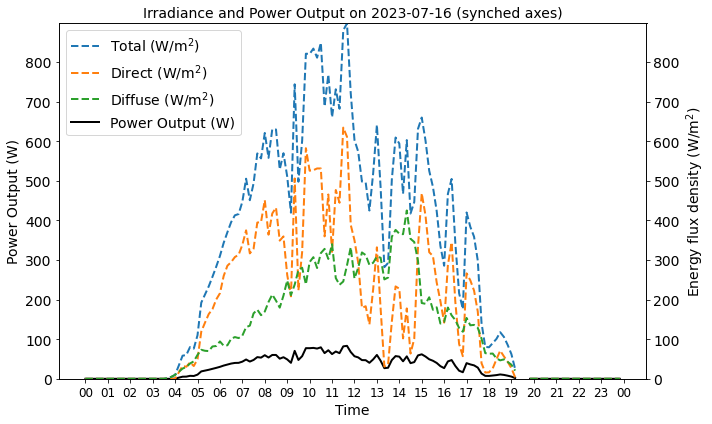

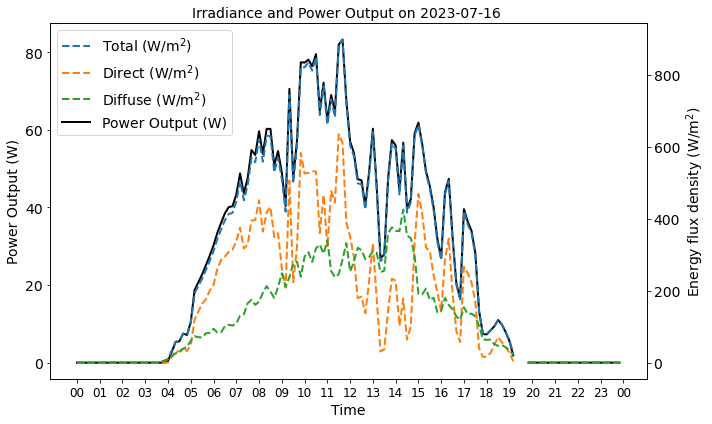

In [ ]:
day = '2023-08-01'

plot_power_and_features(day=day,
                        plot_names=plot_names,
                        features=features,
                        power=power,
                        synchronize_axes=True)

plot_power_and_features(day=day,
                        plot_names=plot_names,
                        features=features,
                        power=power,
                        synchronize_axes=False)

In [ ]:
for day in np.unique(df.index.date):
    plot_power_and_features(day=str(day),
                            plot_names=plot_names,
                            features=features,
                            power=power,
                            synchronize_axes=False) 